## ML Model Breast Cancer Dataset

### Datasource
    1. https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

### Objective
    1. To classify a person into patient or non-patient using collected data.

### Target
    1. Difference between Train - Test Accuracy < 5%
    2. Test Accuracy >= 90%
    3. Recall >= 90%

### Pre-Processing

#### Libraries

In [1]:
import sys
import os

import warnings
warnings.filterwarnings("ignore")

import numpy as np

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams['figure.figsize'] = [12, 10]

import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', -1)

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from scipy import stats

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

# --------------- End of sklearn libraries ---------------------

import catboost as cb

import shap

#### Global Constants

In [2]:
RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.15  # test_size where used is assigned TESTSIZE

scoremet = ['f1'] # Specify the scoring metrics to be used in Hyperparameter Tuning
scoremet_cbc = ['F1'] # CatBoost module nomenclature changes. Watchout.

In [3]:
nscores = len(scoremet)
nscores_cbc = len(scoremet_cbc)

if (nscores == 0) or (nscores_cbc == 0):
    scoremet = ['f1'] # Default evaluation metrics for Scikit ML Models
    scoremet_cbc = ['F1'] # # Default evaluation metrics for CatBoost Classifier
if nscores > 1 or nscores_cbc > 1:
    sys.exit("Only ONE Evaluation Metric Allowed")

#### I/O Path & File Name

In [4]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_BreastCancer_30x1.csv"
PREFIX = r"\MLM_V2.2_BreastCancer_Iteration_1_"

# Specify number of features and targets

n_features = 30
n_target = 1

#### Dataframe Construction

In [5]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.round(decimals=3)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

#### Encoding

In [6]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [7]:
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.40,0.006,0.049,0.054,0.016,0.030,0.006,25.38,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119,M
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,0.544,0.734,3.398,74.08,0.005,0.013,0.019,0.013,0.014,0.004,24.99,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089,M
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.03,0.006,0.040,0.038,0.021,0.022,0.005,23.57,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088,M
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.23,0.009,0.075,0.057,0.019,0.060,0.009,14.91,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173,M
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.44,0.011,0.025,0.057,0.019,0.018,0.005,22.54,16.67,152.20,1575.0,0.137,0.205,0.400,0.162,0.236,0.077,M


In [8]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [9]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [10]:
df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,17.99,10.38,122.80,1001.0,0.118,0.278,0.300,0.147,0.242,0.079,1.095,0.905,8.589,153.40,0.006,0.049,0.054,0.016,0.030,0.006,25.38,17.33,184.60,2019.0,0.162,0.666,0.712,0.265,0.460,0.119,1
1,20.57,17.77,132.90,1326.0,0.085,0.079,0.087,0.070,0.181,0.057,0.544,0.734,3.398,74.08,0.005,0.013,0.019,0.013,0.014,0.004,24.99,23.41,158.80,1956.0,0.124,0.187,0.242,0.186,0.275,0.089,1
2,19.69,21.25,130.00,1203.0,0.110,0.160,0.197,0.128,0.207,0.060,0.746,0.787,4.585,94.03,0.006,0.040,0.038,0.021,0.022,0.005,23.57,25.53,152.50,1709.0,0.144,0.424,0.450,0.243,0.361,0.088,1
3,11.42,20.38,77.58,386.1,0.142,0.284,0.241,0.105,0.260,0.097,0.496,1.156,3.445,27.23,0.009,0.075,0.057,0.019,0.060,0.009,14.91,26.50,98.87,567.7,0.210,0.866,0.687,0.258,0.664,0.173,1
4,20.29,14.34,135.10,1297.0,0.100,0.133,0.198,0.104,0.181,0.059,0.757,0.781,5.438,94.44,0.011,0.025,0.057,0.019,0.018,0.005,22.54,16.67,152.20,1575.0,0.137,0.205,0.400,0.162,0.236,0.077,1


#### Imputing

In [11]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [12]:
print(df.isnull().sum(), end='\n\n')

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis                  0
dtype: int64



In [13]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [14]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [15]:
print(df.isnull().sum(), end='\n\n')

radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
diagnosis                  0
dtype: int64



#### Outlier Treatment

In [16]:
"""
    1. Cell for removing outliers.
    2. Based on Z-score.
"""
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)] # Removing the Outliers using Z-Scored Method

In [17]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']

List of Targets: ['diagnosis']

List of Categorical Variables: ['diagnosis']

List of Categorical Targets ['diagnosis']



#### Descriptive Stats

In [18]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [19]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                         |   count |    mean |     std |   min |    25% |   50% |    75% |   max |
|-------------------------|---------|---------|---------|-------|--------|-------|--------|-------|
| radius_mean             |     495 |  13.869 |   3.043 | 6.981 | 11.745 | 13.21 |  15.29 | 23.27 |
| texture_mean            |     495 |   18.89 |   3.966 |  9.71 |     16 | 18.58 |  21.46 | 30.72 |
| perimeter_mean          |     495 |  89.932 |  20.795 | 43.79 | 75.475 | 85.63 | 100.25 | 152.1 |
| area_mean               |     495 | 622.613 | 286.903 | 143.5 |  424.8 | 538.9 | 718.05 |  1686 |
| smoothness_mean         |     495 |   0.095 |   0.013 | 0.063 |  0.085 | 0.095 |  0.104 | 0.137 |
| compactness_mean        |     495 |   0.095 |   0.041 | 0.019 |  0.062 | 0.085 |   0.12 | 0.228 |
| concavity_mean          |     495 |   0.074 |   0.062 |     0 |  0.028 | 0.053 |  0.107 | 0.317 |
| concave points_mean     |     495 |   0.043 |   0.033 |     0 |   0.02 | 0.031 |  0.063 | 0.156 |


#### Train-Test Split

In [20]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE, stratify=y)


#### Random Over Sampling

In [21]:
# Over Sampling

from imblearn.over_sampling import RandomOverSampler

y_score = y_train.iloc[:, -1].value_counts()

print("Before Upsampling:", y_score)

ros = RandomOverSampler(random_state=RND_STATE)
X_train, y_train = ros.fit_resample(X_train, y_train)

y_score = y_train.iloc[:, -1].value_counts()

print("After Upsampling:", y_score)

Before Upsampling: 0    282
1    138
Name: diagnosis, dtype: int64
After Upsampling: 0    282
1    282
Name: diagnosis, dtype: int64


#### Random Under Sampling

In [22]:
# # Under Sampling

# from imblearn.under_sampling import RandomUnderSampler

# y_score = y_train.iloc[:, -1].value_counts()

# print("Before Downsampling:", y_score)

# rus = RandomUnderSampler(random_state=RND_STATE)
# X_train, y_train = rus.fit_resample(X_train, y_train)

# y_score = y_train.iloc[:, -1].value_counts()

# print("After Undersampling:", y_score)

In [23]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [24]:
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,11.95,14.96,77.23,426.7,0.116,0.121,0.012,0.018,0.246,0.066,0.361,1.050,2.455,26.65,0.006,0.024,0.008,0.011,0.027,0.003,12.81,17.72,83.09,496.2,0.129,0.188,0.031,0.048,0.312,0.076
1,15.71,13.93,102.00,761.7,0.095,0.095,0.071,0.059,0.182,0.057,0.312,0.816,1.972,27.94,0.005,0.015,0.017,0.013,0.017,0.002,17.50,19.25,114.30,922.8,0.122,0.195,0.171,0.137,0.272,0.071
2,10.94,18.59,70.39,370.0,0.100,0.075,0.049,0.029,0.149,0.066,0.380,1.743,3.018,25.78,0.010,0.021,0.020,0.012,0.021,0.003,12.40,25.58,82.76,472.4,0.136,0.164,0.141,0.079,0.225,0.077
3,11.67,20.02,75.21,416.2,0.102,0.095,0.042,0.022,0.186,0.065,0.207,0.874,1.393,15.34,0.005,0.017,0.018,0.005,0.014,0.003,13.35,28.81,87.00,550.6,0.155,0.296,0.276,0.081,0.321,0.090
4,15.46,23.95,103.80,731.3,0.118,0.187,0.203,0.085,0.181,0.071,0.333,1.961,2.937,32.52,0.010,0.049,0.060,0.020,0.021,0.006,17.11,36.33,117.70,909.4,0.173,0.497,0.591,0.216,0.301,0.107


In [25]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [26]:
X_test.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
273,9.742,15.67,61.50,289.9,0.090,0.047,0.011,0.014,0.208,0.063,0.268,1.409,1.750,16.39,0.014,0.011,0.008,0.009,0.018,0.004,10.75,20.88,68.09,355.2,0.147,0.094,0.040,0.052,0.284,0.082
104,10.490,19.29,67.41,336.1,0.100,0.086,0.030,0.012,0.222,0.065,0.355,1.534,2.302,23.13,0.008,0.022,0.029,0.009,0.027,0.003,11.54,23.31,74.22,402.8,0.122,0.149,0.080,0.032,0.283,0.076
19,13.540,14.36,87.46,566.3,0.098,0.081,0.067,0.048,0.188,0.058,0.270,0.789,2.058,23.56,0.008,0.015,0.024,0.013,0.020,0.002,15.11,19.26,99.70,711.2,0.144,0.177,0.239,0.129,0.298,0.073
67,11.310,19.04,71.80,394.1,0.081,0.047,0.037,0.022,0.152,0.057,0.273,0.943,1.831,18.15,0.009,0.009,0.021,0.009,0.022,0.002,12.33,23.84,78.00,466.7,0.129,0.091,0.144,0.070,0.240,0.066
301,12.460,19.89,80.43,471.3,0.085,0.101,0.068,0.031,0.178,0.062,0.364,1.040,2.579,28.32,0.007,0.034,0.047,0.014,0.027,0.005,13.46,23.07,88.13,551.3,0.105,0.216,0.190,0.076,0.268,0.078


In [27]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [28]:
y_train.head()

,diagnosis
0,0
1,0
2,0
3,0
4,1


In [29]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [30]:
y_test.head()

,diagnosis
273,0
104,0
19,0
67,0
301,0


#### Feature Scaling

In [31]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [32]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [33]:
X_train_sc_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-0.847098,-1.177349,-0.831302,-0.875566,1.582551,0.402758,-1.152070,-0.966656,2.879645,0.754684,-0.216550,-0.199591,-0.255024,-0.467278,-0.243764,0.075288,-1.186526,-0.115552,1.389260,-0.229095,-0.951598,-1.487609,-0.955675,-0.908587,-0.227529,-0.528433,-1.398105,-1.219154,0.414585,-0.467379
1,0.287870,-1.434222,0.261728,0.167213,-0.102279,-0.190397,-0.292069,0.179062,0.106705,-0.818529,-0.429851,-0.731446,-0.556497,-0.426295,-0.666789,-0.636375,-0.679128,0.286739,-0.321158,-0.838574,0.074475,-1.223327,0.045630,-0.083290,-0.556210,-0.475445,-0.630464,0.217252,-0.371781,-0.787984
2,-1.151969,-0.272058,-1.133132,-1.052060,0.298871,-0.646670,-0.612747,-0.659269,-1.323093,0.754684,-0.133842,1.375518,0.096383,-0.494918,1.448334,-0.161933,-0.509996,0.085594,0.363009,-0.229095,-1.041298,-0.129924,-0.966262,-0.954630,0.101152,-0.710107,-0.794959,-0.718832,-1.295761,-0.403258
3,-0.931617,0.084572,-0.920439,-0.908250,0.459331,-0.190397,-0.714781,-0.854879,0.280013,0.579882,-0.886924,-0.599618,-0.917891,-0.826597,-0.666789,-0.478228,-0.622751,-1.322424,-0.834284,-0.229095,-0.833457,0.428005,-0.830231,-0.803345,0.993285,0.289100,-0.054734,-0.686554,0.591517,0.430316
4,0.212407,1.064681,0.341157,0.072584,1.743012,1.908459,1.632002,0.905615,0.063378,1.628691,-0.338436,1.871007,0.045825,-0.280788,1.448334,2.052131,1.745102,1.694757,0.363009,1.599343,-0.010849,1.726961,0.154711,-0.109214,1.838464,1.810620,1.672456,1.492264,0.198334,1.520374


In [34]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [35]:
X_test_sc_df.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,-1.513589,-1.000281,-1.525423,-1.301393,-0.503429,-1.285452,-1.166646,-1.078434,1.233212,0.230279,-0.621386,0.616375,-0.695063,-0.793239,3.140433,-0.952670,-1.186526,-0.517842,-0.150116,0.380384,-1.402283,-0.941771,-1.436917,-1.181364,0.617650,-1.239990,-1.348756,-1.154596,-0.135871,-0.082652
1,-1.287803,-0.097484,-1.264632,-1.157583,0.298871,-0.395720,-0.889697,-1.134322,1.839792,0.579882,-0.242669,0.900485,-0.350522,-0.579109,0.602285,-0.082859,-0.002599,-0.517842,1.389260,-0.229095,-1.229447,-0.522029,-1.240250,-1.089278,-0.556210,-0.823654,-1.129431,-1.477384,-0.155530,-0.467379
2,-0.367151,-1.326984,-0.379881,-0.441023,0.138411,-0.509788,-0.350374,-0.128326,0.366668,-0.643728,-0.612680,-0.792814,-0.502819,-0.565448,0.602285,-0.636375,-0.284486,0.286739,0.191967,-0.838574,-0.448407,-1.221599,-0.422779,-0.492650,0.476787,-0.611700,-0.257611,0.088137,0.139357,-0.659742
3,-1.040284,-0.159832,-1.070913,-0.977043,-1.225499,-1.285452,-0.787663,-0.854879,-1.193111,-0.818529,-0.599621,-0.442789,-0.644505,-0.737323,1.025310,-1.110818,-0.453619,-0.517842,0.534051,-0.838574,-1.056612,-0.430480,-1.118976,-0.965657,-0.227529,-1.262699,-0.778509,-0.864087,-1.000874,-1.108589
4,-0.693153,0.052151,-0.690095,-0.736736,-0.904579,-0.053515,-0.335798,-0.603380,-0.066604,0.055478,-0.203491,-0.222320,-0.177627,-0.414222,0.179260,0.866025,1.012195,0.487885,1.389260,0.989864,-0.809392,-0.563485,-0.793978,-0.801991,-1.354434,-0.316480,-0.526285,-0.767251,-0.450418,-0.339137


### Machine Learning Models

#### Tuning Logistic Regression

In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [1000, 100, 10, 1]

grid = {'solver':solvers,
       'penalty':penalty,
       'C':c_values,
        'class_weight':[{0:1, 1:w} for w in [1, 1.05, 1.2, 1.5, 2]]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

LR_Best = grid_search.best_params_

In [37]:
print("------ Logistic Regression Best Parameters ------")

------ Logistic Regression Best Parameters ------


In [38]:
LR_Best

{'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}

#### Logistic Regression

In [39]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(**LR_Best, random_state=RND_STATE).fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[1, 1]
TN_LR = CM[0, 0]
FP_LR = CM[0, 1]
FN_LR = CM[1, 0]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [40]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [41]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [42]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.98,1.00,0.99,50.00
1,1.00,0.96,0.98,25.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.98,0.98,75.00
weighted avg,0.99,0.99,0.99,75.00


#### Tuning Random Forest

In [ ]:
# Hyperparameter Tunining for Random Forest Classifier (RFC)

RFC = RandomForestClassifier()

n_estimators = [100, 200, 300] # Number of Trees in the Forest
max_features = ['auto', 'sqrt']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

RFC_Best = grid_search.best_params_

In [44]:
print("------ Random Forest Best Parameters ------")

------ Random Forest Best Parameters ------


In [45]:
RFC_Best

{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 200}

#### Random Forest

In [46]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(**RFC_Best, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[1, 1]
TN_RFC = CM[0, 0]
FP_RFC = CM[0, 1]
FN_RFC = CM[1, 0]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [47]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [48]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [49]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.98,1.00,0.99,50.00
1,1.00,0.96,0.98,25.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.98,0.98,75.00
weighted avg,0.99,0.99,0.99,75.00


#### Tuning Extra Trees

In [ ]:
# Hyperparameter Tunining for Extra Trees Classifier (ETC)

ETC = ExtraTreesClassifier()

n_estimators = [100, 200, 300] # Number of Trees in the Forest
max_features = ['auto', 'sqrt']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']
weights = [1]

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'class_weight':  [{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=ETC, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

ETC_Best = grid_search.best_params_

In [51]:
print("------ Extra Trees Best Parameters ------")

------ Extra Trees Best Parameters ------


In [52]:
ETC_Best

{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 200}

#### Extra Trees

In [53]:
# Model: Extra Trees (ETC) 

ETC = RandomForestClassifier(**ETC_Best, random_state=RND_STATE)
ETC.fit(X_train_sc, y_train)

# Prediction

y_pred = ETC.predict(X_test_sc)

Train_Acc_ETC = round(ETC.score(X_train_sc, y_train),2)
Test_Acc_ETC = round(ETC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_ETC = CM[1, 1]
TN_ETC = CM[0, 0]
FP_ETC = CM[0, 1]
FN_ETC = CM[1, 0]

Precision_ETC = round(TP_ETC/(TP_ETC + FP_ETC), 2)
Recall_ETC = round(TP_ETC/(TP_ETC+FN_ETC), 2)
f1_ETC = round((2*Precision_ETC*Recall_ETC)/(Precision_ETC+Recall_ETC), 2)
Specificity_ETC = round(TN_ETC/(TN_ETC+FP_ETC), 2)
AUC_ETC = round(roc_auc_score(y_test, y_pred), 2)

fpr_ETC, tpr_ETC, threshold_ETC = roc_curve(y_test, y_pred, pos_label=1)

In [54]:
ETC_Rep = classification_report(y_test, y_pred, output_dict=True)
ETC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [55]:
print("-------- Extra Trees Summary -------- ")

-------- Extra Trees Summary -------- 


In [56]:
ETC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.98,1.00,0.99,50.00
1,1.00,0.96,0.98,25.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.98,0.98,75.00
weighted avg,0.99,0.99,0.99,75.00


#### Tuning Kernel SVM

In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['rbf']
c_values = [1000, 100, 10, 1]
gamma = [0.1, 0.01]
weights = [1]

grid = {'kernel':kernel,
       'C':c_values,
        'gamma':gamma,
        'class_weight':[{0:1, 1:weights} for weights in weights]
       }

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring=scoremet[0], error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

KSV_Best = grid_search.best_params_

In [58]:
print("------ Kernel SVM Best Parameters ------")

------ Kernel SVM Best Parameters ------


In [59]:
KSV_Best

{'C': 1000, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.01, 'kernel': 'rbf'}

#### Kernel SVM

In [60]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(**KSV_Best, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[1, 1]
TN_KSV = CM[0, 0]
FP_KSV = CM[0, 1]
FN_KSV = CM[1, 0]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [61]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [62]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [63]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.98,1.00,0.99,50.00
1,1.00,0.96,0.98,25.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.98,0.98,75.00
weighted avg,0.99,0.99,0.99,75.00


#### Tuning CatBoost

In [ ]:
# Model: Hyperparameter Tuning for CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

learning_rate = [0.01, 0.1]
depth= [4, 6, 10]
l2_leaf_reg =  [1, 3, 5,]
iterations = [100, 200, 300]
weights=[1.0, 2.0]

CBC = cb.CatBoostClassifier(loss_function='Logloss', eval_metric=scoremet_cbc[0])

grid = {'learning_rate':learning_rate,
        'depth': depth,
        'l2_leaf_reg':l2_leaf_reg,
        'iterations':iterations,
#         'class_weights': [{0:1, 1:weights} for weights in weights]
       }

CBC.grid_search(grid, train_dataset)
CBC.get_params ()
CBC_Best = CBC.get_params()

In [65]:
print("------ CatBoost Classification Best Parameters ------")

------ CatBoost Classification Best Parameters ------


In [66]:
CBC_Best

{'loss_function': 'Logloss',
 'eval_metric': 'F1',
 'depth': 4,
 'l2_leaf_reg': 1,
 'iterations': 200,
 'learning_rate': 0.1}

#### CatBoost

In [ ]:
# Model: CatBoost Classification (CBC)

CBC= cb.CatBoostClassifier(**CBC_Best, random_seed=RND_STATE)
CBC.fit(X_train_sc, y_train)

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[1, 1]
TN_CBC = CM[0, 0]
FP_CBC = CM[0, 1]
FN_CBC = CM[1, 0]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [68]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [69]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [70]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.98,1.00,0.99,50.00
1,1.00,0.96,0.98,25.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.98,0.98,75.00
weighted avg,0.99,0.99,0.99,75.00


#### Multi-Layer Perceptron

In [71]:
# Multi Layer Perceptron Classifier - MLP

MLP = MLPClassifier(hidden_layer_sizes=(300, 300), max_iter=300, alpha=1e-4, activation='relu', solver='adam', random_state=RND_STATE)
MLP.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = MLP.predict(X_test_sc).astype(int)

Train_Acc_MLP = round(MLP.score(X_train_sc, y_train),2)
Test_Acc_MLP = round(MLP.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_MLP = CM[1, 1]
TN_MLP = CM[0, 0]
FP_MLP = CM[0, 1]
FN_MLP = CM[1, 0]

Precision_MLP = round(TP_MLP/(TP_MLP + FP_MLP), 2)
Recall_MLP = round(TP_MLP/(TP_MLP + FN_MLP), 2)
f1_MLP = round((2*Precision_MLP*Recall_MLP)/(Precision_MLP+Recall_MLP), 2)
Specificity_MLP = round(TN_MLP/(TN_MLP+FP_MLP), 2)
AUC_MLP = round(roc_auc_score(y_test, y_pred), 2)

fpr_MLP, tpr_MLP, threshold_MLP = roc_curve(y_test, y_pred, pos_label=1)

In [72]:
MLP_Rep = classification_report(y_test, y_pred, output_dict=True)
MLP_Rep_df = pd.DataFrame(MLP_Rep).transpose()

MLP_Best = {}

In [73]:
print("-------- Multi Layer Perceptron Classifier -------- ")

-------- Multi Layer Perceptron Classifier -------- 


In [74]:
MLP_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.98,1.00,0.99,50.00
1,1.00,0.96,0.98,25.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.98,0.98,75.00
weighted avg,0.99,0.99,0.99,75.00


#### Voting Classifier

In [75]:
# Voting Classifier

VOC = VotingClassifier(estimators=[('RFC', RFC), ('ETC', ETC)], voting='soft',
                       weights=[1,1], flatten_transform=True, n_jobs=-1)
VOC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = VOC.predict(X_test_sc).astype(int)

Train_Acc_VOC = round(VOC.score(X_train_sc, y_train),2)
Test_Acc_VOC = round(VOC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_VOC = CM[1, 1]
TN_VOC = CM[0, 0]
FP_VOC = CM[0, 1]
FN_VOC = CM[1, 0]

Precision_VOC = round(TP_VOC/(TP_VOC + FP_VOC), 2)
Recall_VOC = round(TP_VOC/(TP_VOC + FN_VOC), 2)
f1_VOC = round((2*Precision_VOC*Recall_VOC)/(Precision_VOC+Recall_VOC), 2)
Specificity_VOC = round(TN_VOC/(TN_VOC+FP_VOC), 2)
AUC_VOC = round(roc_auc_score(y_test, y_pred), 2)

fpr_VOC, tpr_VOC, threshold_VOC = roc_curve(y_test, y_pred, pos_label=1)

In [76]:
VOC_Rep = classification_report(y_test, y_pred, output_dict=True)
VOC_Rep_df = pd.DataFrame(VOC_Rep).transpose()

VOC_Best = {}

In [77]:
print("-------- Votiing Classifier -------- ")

-------- Votiing Classifier -------- 


In [78]:
VOC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.98,1.00,0.99,50.00
1,1.00,0.96,0.98,25.00
accuracy,0.99,0.99,0.99,0.99
macro avg,0.99,0.98,0.98,75.00
weighted avg,0.99,0.99,0.99,75.00


#### Stacking Classifier

In [79]:
# Stacking Classifier

STC = StackingClassifier(estimators=[('RFC', RFC), ('ETC', ETC)], final_estimator=MLP, passthrough=False, n_jobs=-1)
STC.fit(X_train_sc, y_train)

# Evaluate the Model

y_pred = STC.predict(X_test_sc).astype(int)

Train_Acc_STC = round(STC.score(X_train_sc, y_train),2)
Test_Acc_STC = round(STC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_STC = CM[1, 1]
TN_STC = CM[0, 0]
FP_STC = CM[0, 1]
FN_STC = CM[1, 0]

Precision_STC = round(TP_STC/(TP_STC + FP_STC), 2)
Recall_STC = round(TP_STC/(TP_STC + FN_STC), 2)
f1_STC = round((2*Precision_STC*Recall_STC)/(Precision_STC+Recall_STC), 2)
Specificity_STC = round(TN_STC/(TN_STC+FP_STC), 2)
AUC_STC = round(roc_auc_score(y_test, y_pred), 2)

fpr_STC, tpr_STC, threshold_STC = roc_curve(y_test, y_pred, pos_label=1)

In [80]:
STC_Rep = classification_report(y_test, y_pred, output_dict=True)
STC_Rep_df = pd.DataFrame(STC_Rep).transpose()

STC_Best = {}

In [81]:
print("-------- Stacking Classifier -------- ")

-------- Stacking Classifier -------- 


In [82]:
STC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.96,1.00,0.98,50.00
1,1.00,0.92,0.96,25.00
accuracy,0.97,0.97,0.97,0.97
macro avg,0.98,0.96,0.97,75.00
weighted avg,0.97,0.97,0.97,75.00


### Results & Output

#### Output to Excel

In [83]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Extra_Trees', 'Kernel_SVM', 'CatBoost', 'MLP', 'VOC', 'STC']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_ETC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_MLP', 'Train_Acc_VOC', 'Train_Acc_STC']
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_ETC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_MLP', 'Test_Acc_VOC', 'Test_Acc_STC']
score3 = ['TP_LR', 'TP_RFC', 'TP_ETC', 'TP_KSV',  'TP_CBC', 'TP_MLP', 'TP_VOC', 'TP_STC']
score4 = ['TN_LR', 'TN_RFC', 'TN_ETC', 'TN_KSV', 'TN_CBC', 'TN_MLP', 'TN_VOC', 'TN_STC']
score5 = ['FP_LR', 'FP_RFC', 'FP_ETC', 'FP_KSV', 'FP_CBC', 'FP_MLP', 'FP_VOC', 'FP_STC']
score6 = ['FN_LR', 'FN_RFC', 'FN_ETC', 'FN_KSV', 'FN_CBC', 'FN_MLP', 'FN_VOC', 'FN_STC']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_ETC', 'Precision_KSV', 'Precision_CBC', 'Precision_MLP', 'Precision_VOC', 'Precision_STC']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_ETC', 'Recall_KSV', 'Recall_CBC', 'Recall_MLP', 'Recall_VOC', 'Recall_STC']
score9 = ['f1_LR', 'f1_RFC', 'f1_ETC', 'f1_KSV', 'f1_CBC', 'f1_MLP', 'f1_VOC', 'f1_STC']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_ETC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_MLP', 'Specificity_VOC', 'Specificity_STC']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_ETC', 'AUC_KSV', 'AUC_CBC', 'AUC_MLP', 'AUC_VOC', 'AUC_STC']
score12 = ['LR_Best',  'RFC_Best', 'ETC_Best', 'KSV_Best', 'CBC_Best', 'MLP_Best', 'VOC_Best', 'STC_Best']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []
bestparlst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    var12 = vars()[score12[i]]
    
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)
    bestparlst.append(var12)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst, bestparlst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC', 'Best_Params'])

#### Model Evaluation Summary

In [84]:
print("Evaluation Summary:")

Evaluation Summary:


In [85]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC,Best_Params
0,Logistic_Regression,0.99,0.99,24,50,0,1,1.0,0.96,0.98,1.0,0.98,"{'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2', 'solver': 'liblinear'}"
1,Random_Forest,1.0,0.99,24,50,0,1,1.0,0.96,0.98,1.0,0.98,"{'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}"
2,Extra_Trees,1.0,0.99,24,50,0,1,1.0,0.96,0.98,1.0,0.98,"{'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}"
3,Kernel_SVM,1.0,0.99,24,50,0,1,1.0,0.96,0.98,1.0,0.98,"{'C': 1000, 'class_weight': {0: 1, 1: 1}, 'gamma': 0.01, 'kernel': 'rbf'}"
4,CatBoost,1.0,0.99,24,50,0,1,1.0,0.96,0.98,1.0,0.98,"{'loss_function': 'Logloss', 'eval_metric': 'F1', 'depth': 4, 'l2_leaf_reg': 1, 'iterations': 200, 'learning_rate': 0.1}"
5,MLP,1.0,0.99,24,50,0,1,1.0,0.96,0.98,1.0,0.98,{}
6,VOC,1.0,0.99,24,50,0,1,1.0,0.96,0.98,1.0,0.98,{}
7,STC,1.0,0.97,23,50,0,2,1.0,0.92,0.96,1.0,0.96,{}


In [86]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, ETC_Rep_df, KSV_Rep_df, CBC_Rep_df, MLP_Rep_df, VOC_Rep_df, STC_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'ETC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'MLP_Rep_df', 'VOC_Rep_df', 'STC_Rep_df'])).round(decimals=2)

In [87]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [88]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0             0.98       1.00    0.99      50.00  
           1             1.00       0.96    0.98      25.00  
           accuracy      0.99       0.99    0.99      0.99   
           macro avg     0.99       0.98    0.98      75.00  
           weighted avg  0.99       0.99    0.99      75.00  
RFC_Rep_df 0             0.98       1.00    0.99      50.00  
           1             1.00       0.96    0.98      25.00  
           accuracy      0.99       0.99    0.99      0.99   
           macro avg     0.99       0.98    0.98      75.00  
           weighted avg  0.99       0.99    0.99      75.00  
ETC_Rep_df 0             0.98       1.00    0.99      50.00  
           1             1.00       0.96    0.98      25.00  
           accuracy      0.99       0.99    0.99      0.99   
           macro avg     0.99       0.98    0.98      75.00  
           weighted avg  0.99       0.99    0.99      75.00  
KSV_Rep_df 0             0.98       1.00    0.99      50.00  
           1             1.00       0.96    0.98      25.00  
           accuracy      0.99       0.99    0.99      0.99   
           macro avg     0.99       0.98    0.98      75.00  
           weighted avg  0.99       0.99    0.99      75.00  
CBC_Rep_df 0             0.98       1.00    0.99      50.00  
           1             1.00       0.96    0.98      25.00  
           accuracy      0.99       0.99    0.99      0.99   
           macro avg     0.99       0.98    0.98      75.00  
           weighted avg  0.99       0.99    0.99      75.00  
MLP_Rep_df 0             0.98       1.00    0.99      50.00  
           1             1.00       0.96    0.98      25.00  
           accuracy      0.99       0.99    0.99      0.99   
           macro avg     0.99       0.98    0.98      75.00  
           weighted avg  0.99       0.99    0.99      75.00  
VOC_Rep_df 0             0.98       1.00    0.99      50.00  
           1             1.00       0.96    0.98      25.00  
           accuracy      0.99       0.99    0.99      0.99   
           macro avg     0.99       0.98    0.98      75.00  
           weighted avg  0.99       0.99    0.99      75.00  
STC_Rep_df 0             0.96       1.00    0.98      50.00  
           1             1.00       0.92    0.96      25.00  
           accuracy      0.97       0.97    0.97      0.97   
           macro avg     0.98       0.96    0.97      75.00  
           weighted avg  0.97       0.97    0.97      75.00

#### ROC Curve

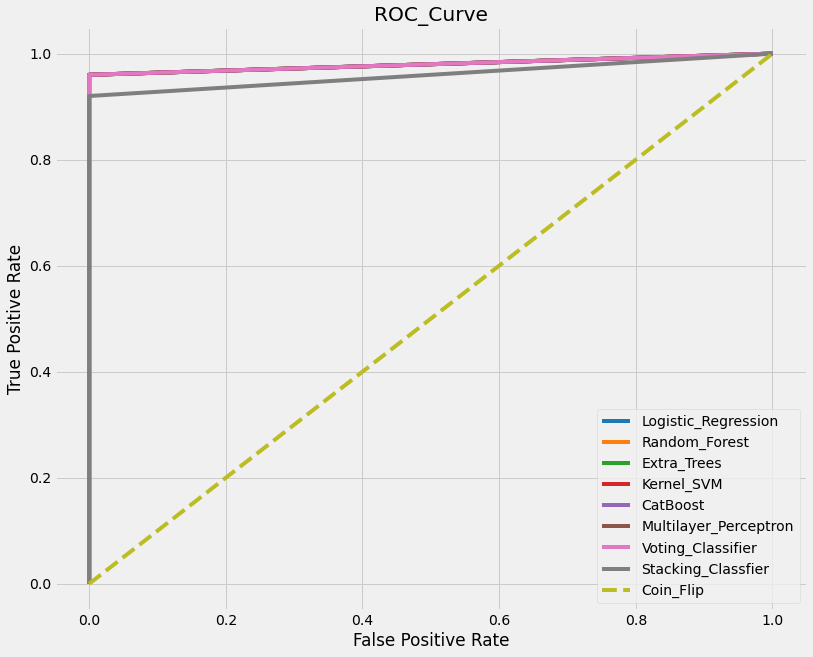

In [89]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='-', color='tab:blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='-', color='tab:orange', label='Random_Forest')
plt.plot(fpr_ETC, tpr_ETC, linestyle='-', color='tab:green', label='Extra_Trees')
plt.plot(fpr_KSV, tpr_KSV, linestyle='-', color='tab:red', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='-', color='tab:purple', label='CatBoost')
plt.plot(fpr_MLP, tpr_MLP, linestyle='-', color='tab:brown', label='Multilayer_Perceptron')
plt.plot(fpr_VOC, tpr_VOC, linestyle='-', color='tab:pink', label='Voting_Classifier')
plt.plot(fpr_STC, tpr_STC, linestyle='-', color='tab:grey', label='Stacking_Classfier')
plt.plot(prob_fpr, prob_tpr, linestyle='--', color='tab:olive', label="Coin_Flip")
plt.xlim([-0.05, 1.05])
plt.ylim([-.05, 1.05])
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

#### Precision Recall Curve

Text(0.5, 1.0, 'Precision-Recall curve')

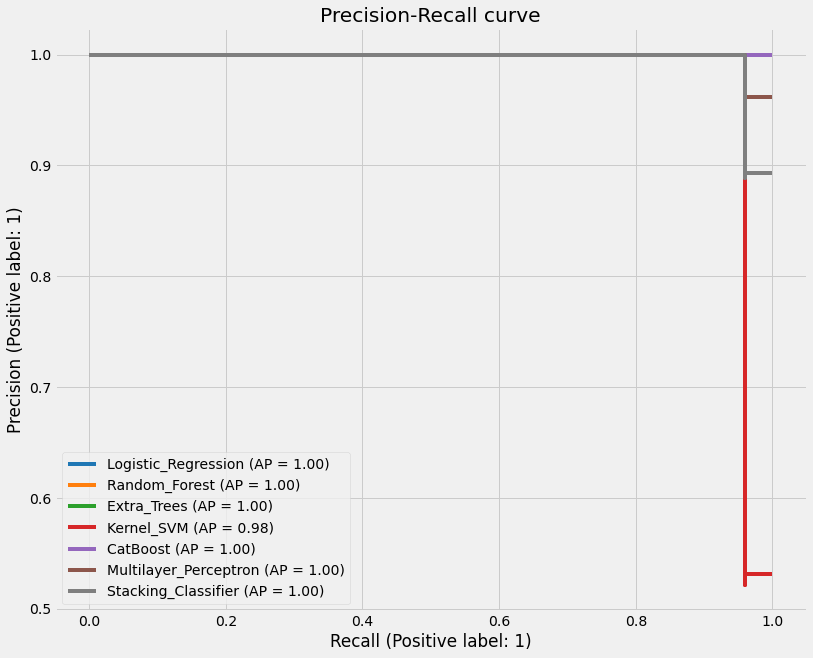

In [90]:
from sklearn.metrics import plot_precision_recall_curve

plot_precision_recall_curve(Log_Reg, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:blue', name = "Logistic_Regression")
plot_precision_recall_curve(RFC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:orange', name = "Random_Forest")
plot_precision_recall_curve(ETC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:green', name = "Extra_Trees")
plot_precision_recall_curve(KSV, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:red', name = "Kernel_SVM")
plot_precision_recall_curve(CBC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:purple', name = "CatBoost")
plot_precision_recall_curve(MLP, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:brown', name = "Multilayer_Perceptron")
plot_precision_recall_curve(STC, X_test_sc, y_test, ax = plt.gca(), linestyle='-', color='tab:grey', name = "Stacking_Classifier")
plt.legend(loc='best')
plt.title('Precision-Recall curve')

#### SHAP Model Explainer

In [91]:
# Model Explainability Using SHAP - CatBoost Classifier

explainer = shap.TreeExplainer(CBC) # Only works for tree based models such as DTC, RFC, ETC, CatBoost 
shap_values = explainer.shap_values(X_train_sc)

In [92]:
print("------ Feature Importance Using SHAP ------")

------ Feature Importance Using SHAP ------


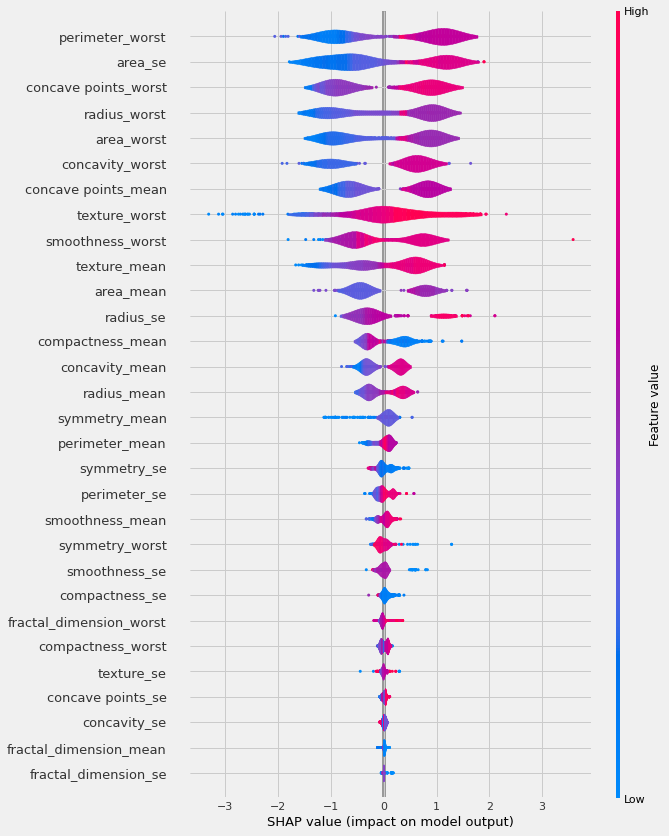

In [93]:
shap.summary_plot(shap_values, X_train_sc, feature_names=featlst, plot_type='violin', max_display=len(featlst), title='CatBoost Model Explainer')

In [94]:
OUTFILE = r"Summary.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='Metrics', index=False)
Classification_Report_Summary.to_excel(writer, sheet_name='CLF_Report', index=True)
writer.save()

#### Notebook to HTML

In [95]:
# !jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" GS_MLM_CLF_V2.2.ipynb --to html

In [97]:
NB_Convert = u"jupyter nbconvert --to html_toc --output " # Trailing space is required.
NB_Name = u"GS_MLM_CLF_V2.2_BreastCancer.ipynb"
PREFIX_A = PREFIX[:-1]
HTML_Name = PREFIX_A.replace("\\", "") + " " # Trailing space is required.
Names_Concat = NB_Convert + HTML_Name + NB_Name
try:
    if(__IPYTHON__):
        get_ipython().system(Names_Concat)
except NameError:
    pass

[NbConvertApp] Converting notebook GS_MLM_CLF_V2.2_BreastCancer.ipynb to html_toc
[NbConvertApp] Support files will be in MLM_V2.2_BreastCancer_Iteration_1_files\
[NbConvertApp] Making directory MLM_V2.2_BreastCancer_Iteration_1_files
[NbConvertApp] Making directory MLM_V2.2_BreastCancer_Iteration_1_files
[NbConvertApp] Making directory MLM_V2.2_BreastCancer_Iteration_1_files
[NbConvertApp] Writing 525262 bytes to MLM_V2.2_BreastCancer_Iteration_1.html
